Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!nvidia-smi

Thu Jul 23 17:39:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |    353MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 4.8MB/s 
     |████████████████████████████████| 1.1MB 13.5MB/s 
     |████████████████████████████████| 890kB 28.3MB/s 
     |████████████████████████████████| 3.0MB 46.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ca75fa08ffa014b51871b9d08d3d383e1e12dd988b89692830260b6c0deec22b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Put the `train.csv` and `test.csv` in your Google Drive in a folder named `dl_data`.

In [ ]:
import pandas as pd

folder = "drive/My Drive/dl_data/"
train_file = folder + "train.csv"
test_file = folder + "test.csv"

train_df = pd.read_csv(train_file)#.sample(50)
test_df = pd.read_csv(test_file)#.sample(1000)

print("Train size:", len(train_df), "Test size:", len(test_df))
print(train_df.head())

Train size: 25000 Test size: 25000
                                              review  sentiment
0  Now here is a film that if made in Australia w...          0
1  It pains me to write such a scathing review bu...          0
2  Lord Alan Cunningham(Antonio De Teffè)is a nut...          0
3  This dreadful film assembles every Asian stere...          0
4  Recap: Ron is about to marry Mel. They are dee...          0


In [ ]:
from transformers import BertTokenizer

print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

Loading BERT tokenizer...


Example Tokenization:

In [ ]:
def encode_df(df):
  reviews = df["review"].values
  labels = df["sentiment"].values
  input_ids = []
  attention_masks = []

  for review in reviews:
      encoded_dict = tokenizer.encode_plus(
          review,
          add_special_tokens = True,
          max_length=512,
          truncation = True,
          pad_to_max_length = True,
          return_attention_mask = True,
          return_tensors = "pt",
      )

      input_ids.append(encoded_dict["input_ids"])
      attention_masks.append(encoded_dict["attention_mask"])
    
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels_tensor = torch.tensor(labels)
  return input_ids, attention_masks, labels_tensor

In [ ]:
from torch.utils.data import TensorDataset, random_split

input_ids, attention_masks, labels = encode_df(train_df)
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = 24999 # int(0.8 * len(dataset)) #24999
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print("Train Size:", train_size, "Validation Size:", val_size)

example_id = 0
example_review = train_df.iloc[0, example_id]
print("Original:", example_review)
print("Token IDs:", input_ids[example_id])
print(len(input_ids[example_id]))

Train Size: 24999 Validation Size: 1
Original: Now here is a film that if made in Australia would have easily been a comedy. Sadly and annoyingly, here it is, flaccid and cheesy and overbaked from Lala land. How did the di-erector get it so wrong? Well, mainly by being serious about a job so hilariously startling that nobody in their right mind could take seriously. Unless of course they were a nerdy lonely gay cliché (but somehow cute)...or is that cliché piled upon cliché. No value in the story that almost seems like a prequel to Gus Van Sant's GERRY..... and with a title like THE FLUFFER how is it all such a lead weight? Well this auteur must have soooooo mad that he didn't get to Burt and BOOGIE first that he had to make his own. Convoluted and undeveloped apart from the 'unrequited love's a bore' theme left over from a faded Streisand lyric, we have only moody beefcake and TV serial level storyline left. The un necessary fourth act of this overlong turgid drama is truly terrible a

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# This is the maximum batch size the gpu can handle simultaneously 
gpu_batch_size = 8
batch_size = 32
num_steps_before_update = batch_size / gpu_batch_size

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = gpu_batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = gpu_batch_size
)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
import math
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8,
)

epochs = 2
updates_per_epoch = int(math.ceil(len(train_dataset) / batch_size))
print("Updates per epoch:", updates_per_epoch)
total_steps = updates_per_epoch * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Updates per epoch: 782


In [ ]:
import numpy as np
import time
import datetime

def flat_hits(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    hits = np.sum(pred_flat == labels_flat)
    return hits

def flat_accuracy(preds, labels):
    return flat_hits(preds, labels) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def eval_model(model, dataloader):
    model.eval()
    total_eval_hits, total_eval_loss, n = 0, 0, 0
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_n = len(b_input_ids)
        with torch.no_grad():
            loss, logits = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
        total_eval_loss += loss.item() * b_n
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()
        total_eval_hits += flat_hits(logits, label_ids)
        n += b_n
    avg_eval_accuracy = total_eval_hits / n
    avg_eval_loss = total_eval_loss / n
    return {
        "avg_accuracy": avg_eval_accuracy,
        "avg_loss": avg_eval_loss,
    }

In [ ]:
import random

seed_val = 43

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(epochs):
    print("")
    print("===== Epoch {:} / {:} =====".format(epoch_i + 1, epochs))
    print("Training...")
    t0 = time.time()
    
    total_train_loss = 0
    agg_loss = 0.0
    num_updates = 0
    optimizer.zero_grad()
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 400 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print("Batch {:>5,} of {:>5,}. Elapsed: {:}".format(step, len(train_dataloader), elapsed))
        # batch = tuple(t.to(device) for t in batch)
        # b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device) 

        
        loss, _ = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
        loss.backward()
        agg_loss += loss

        total_train_loss += loss.item()
        if (step + 1) % num_steps_before_update == 0 or (step + 1) == len(train_dataloader):
            num_updates += 1
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Num updates {}, expected updates {}".format(num_updates, updates_per_epoch))
    print("Average training loss: {}".format(avg_train_loss))
    print("Training Epoch took: {:}".format(training_time))

    t0 = time.time()

    eval_results = eval_model(model, validation_dataloader)
    avg_eval_accuracy = eval_results["avg_accuracy"]
    avg_eval_loss = eval_results["avg_loss"]
    validation_time = format_time(time.time() - t0)

    print("Validation accuracy: {0:.2f}".format(avg_eval_accuracy))
    print("Validation loss: {}".format(avg_eval_loss))
    print("Validation took: {:}".format(validation_time))

    training_stats.append({
        "epoch": epoch_i + 1,
        "training_loss": avg_train_loss,
        "validation_loss": avg_eval_loss,
        "validation_acc": avg_eval_accuracy,
        "training_time": training_time,
        "validation_time": validation_time,
    })

print("")
print("Training Complete")
print("Training took: {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


===== Epoch 1 / 2 =====
Training...
Batch   400 of 3,125. Elapsed: 0:02:48
Batch   800 of 3,125. Elapsed: 0:05:35
Batch 1,200 of 3,125. Elapsed: 0:08:22
Batch 1,600 of 3,125. Elapsed: 0:11:09
Batch 2,000 of 3,125. Elapsed: 0:13:56
Batch 2,400 of 3,125. Elapsed: 0:16:44
Batch 2,800 of 3,125. Elapsed: 0:19:31
Num updates 782, expected updates 782
Average training loss: 0.23296988146662712
Training Epoch took: 0:21:47
Validation accuracy: 1.00
Validation loss: 0.025751471519470215
Validation took: 0:00:00

===== Epoch 2 / 2 =====
Training...
Batch   400 of 3,125. Elapsed: 0:02:48
Batch   800 of 3,125. Elapsed: 0:05:35
Batch 1,200 of 3,125. Elapsed: 0:08:23
Batch 1,600 of 3,125. Elapsed: 0:11:10
Batch 2,000 of 3,125. Elapsed: 0:13:57
Batch 2,400 of 3,125. Elapsed: 0:16:44
Batch 2,800 of 3,125. Elapsed: 0:19:31
Num updates 782, expected updates 782
Average training loss: 0.11287761781454086
Training Epoch took: 0:21:47
Validation accuracy: 1.00
Validation loss: 0.012184381484985352
Validat

In [ ]:
pd.set_option("precision", 4)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index("epoch")
df_stats

,training_loss,validation_loss,validation_acc,training_time,validation_time
epoch,,,,,
1,0.2330,0.0258,1.0,0:21:47,0:00:00
2,0.1129,0.0122,1.0,0:21:47,0:00:00


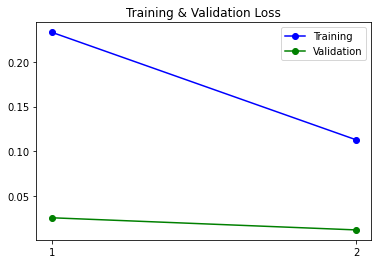

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_stats["training_loss"], "b-o", label="Training")
plt.plot(df_stats["validation_loss"], "g-o", label="Validation")

plt.title("Training & Validation Loss")
plt.legend()

plt.xticks(np.arange(1, len(df_stats)+1, dtype=int))
plt.show()

Evaluate Test Dataset


In [ ]:
test_dataset = TensorDataset(*encode_df(test_df))

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
t0 = time.time()

test_results = eval_model(model, test_dataloader)
avg_test_accuracy = test_results["avg_accuracy"]
avg_test_loss = test_results["avg_loss"]
test_time = format_time(time.time() - t0)

print("Test accuracy: {0:.4f}".format(avg_test_accuracy))
print("Test loss: {}".format(avg_test_loss))
print("Testing took: {:}".format(test_time))

Test accuracy: 0.9406
Test loss: 0.16848376241445542
Testing took: 0:06:41


In [ ]:
import os

output_dir = folder + "model_checkpoint_final/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving Model to:", output_dir)

model_to_save = model.module if hasattr(model, "module") else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving Model to: drive/My Drive/dl_data/model_checkpoint_final/


('drive/My Drive/dl_data/model_checkpoint_final/vocab.txt',
 'drive/My Drive/dl_data/model_checkpoint_final/special_tokens_map.json',
 'drive/My Drive/dl_data/model_checkpoint_final/added_tokens.json')

In [ ]:
os.environ["OUTPUT_DIR"] = output_dir
!ls -l --block-size=K "$OUTPUT_DIR"

total 427947K
-rw------- 1 root root      1K Jul 23 15:23 config.json
-rw------- 1 root root 427719K Jul 23 15:23 pytorch_model.bin
-rw------- 1 root root      1K Jul 23 15:23 special_tokens_map.json
-rw------- 1 root root      1K Jul 23 15:23 tokenizer_config.json
-rw------- 1 root root    227K Jul 23 15:23 vocab.txt


In [ ]:
# Load Model

model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

model.to(device)